## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169990, 8)


In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

All caught up..!
size of dataset: (167127, 8)


In [6]:
#dir(crypto.binance_client)
crypto.binance_client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locked': '0.00000000'},
  {'asset': 'HSR', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'OAX', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'DNT', 'free': '0.000000

### Generate Candles and build features from technical analysis

In [7]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [8]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [9]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

271

,Close,Pred Close
Date,,
2022-05-08 03:01:00,34438.88,34975.962489
2022-05-08 03:16:00,34456.16,34922.834632
2022-05-08 03:31:00,34354.99,34773.218389
2022-05-08 03:46:00,34480.24,34726.790841
2022-05-08 04:01:00,34609.80,34664.006944
...,...,...
2022-06-28 15:31:00,20631.98,21008.092016
2022-06-28 15:46:00,20606.40,20985.843847
2022-06-28 16:01:00,20649.32,20981.775217


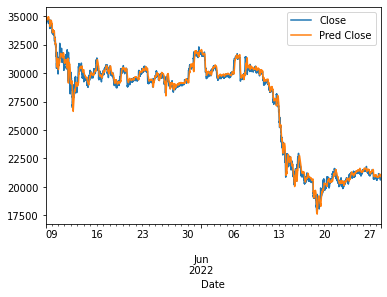

In [10]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

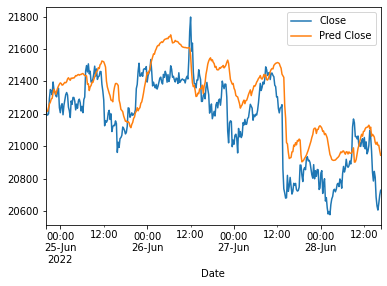

In [14]:
df_preds_true.dropna().iloc[-new_time_steps-100:].plot()

In [21]:
wallet_hist_df

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-06-23 01:31:00,-42.34275,-42.34275
2022-06-23 01:31:00,-72.00625,-29.66350
2022-06-23 01:31:00,-39.72400,32.28225
2022-06-23 01:31:00,33.88850,73.61250
2022-06-23 01:31:00,102.23600,68.34750
2022-06-23 01:31:00,-70.35350,-172.58950
2022-06-23 01:31:00,-149.65775,-79.30425
2022-06-23 01:31:00,-146.83025,2.82750
2022-06-23 01:31:00,-199.76125,-52.93100


Fee: 0.025
----------------------
Buy      38 ( 25 ok 13 ko )
Avg PCT gain: 1.0021820210184078
Avg PCT loss: 0.9979655315634421
Wins  PCT   0.6578947368421053
Avg PCT Gain.    1.0021820210184078
No-op    0
Wallet   541.5239999999994
Drawback -251.89375
Kelly Fraction    0.317228816243088
Total earned 541.5239999999994


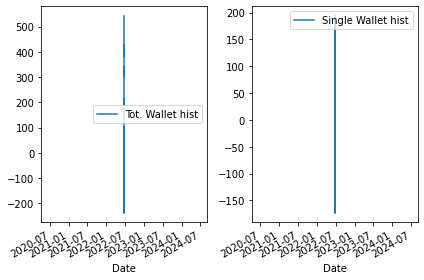

In [17]:
wallet_hist_df,wallet,kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-new_time_steps*2:], ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,wallet_hist_df)

All caught up..!
size of dataset: (169990, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (169990, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (169990, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (169990, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature

KeyboardInterrupt: ignored

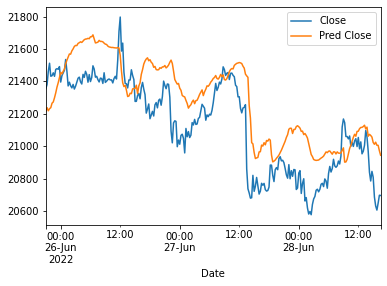

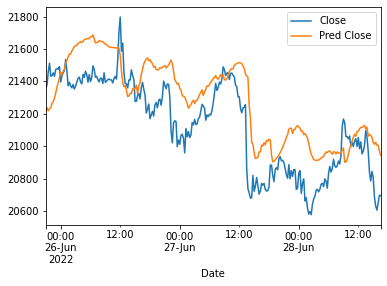

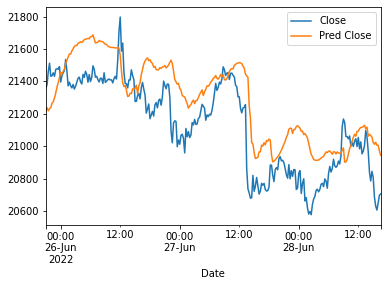

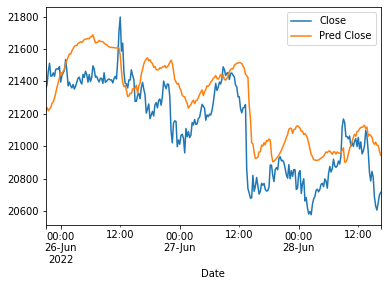

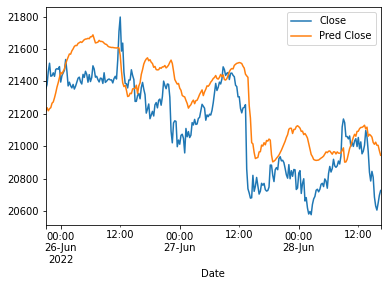

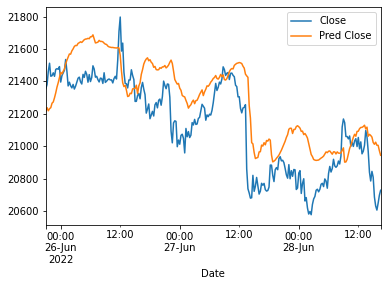

In [13]:
investment = 100.
conservative_kelly = kelly_frac*.5
portfolio = investment
order_status = "not_filled"

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts()
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  fee = 0.025

  elapsed_minutes = (pd.Timestamp(datetime.now()) - df_preds_true.index[-1]).seconds/crypto.dt
  time_condition = delta.seconds/crypto.dt -1. < elapsed_minutes <  delta.seconds/crypto.dt + 1.

  if time_condition and order_status == "not_filled" :

    if prev_true_close*(1+fee) < pred_close:

        #get price
        price = crypto.binance_client.get_symbol_ticker(symbol=tickers[0])
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(price['price']))
        buy_quantity = 0.001
        order = crypto.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
        
        order_status= "filled"
        






In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

In [ ]:
df_preds_true